# Data for the Entire Season

This section explores how much data would be needed to analyze the entire area of Brandenburg, Germany, over an entire year. This was explored to verify the feasibility of comparing data for an entire year with official numbers as provided by the Waldbrandstatistik published by the responsible ministry, the Landesbetrieb Forst Brandenburg.

Data in the year 2018 is looked at to provide an estimate of the required resources.

<AxesSubplot:>

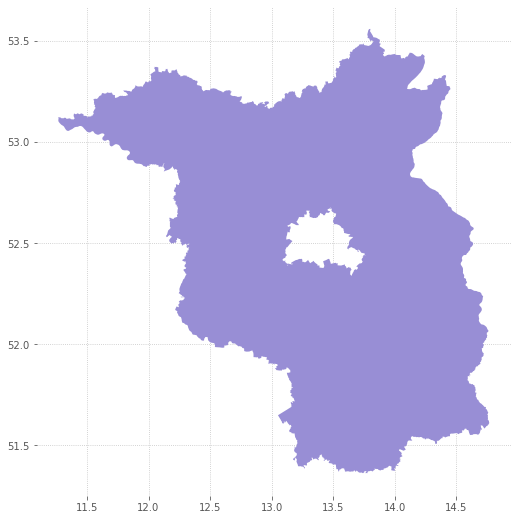

In [2]:
from datetime import date
import os
from sentinel_helpers import search_osm
from sentinelsat import SentinelAPI
from tqdm.notebook import tqdm

api = SentinelAPI(os.getenv('SCIHUB_USERNAME'), os.getenv('SCIHUB_PASSWORD'))
api._tqdm = tqdm

start_date = date(2018, 1, 1)
end_date = date(2018, 12, 31)
cloud_coverage = (0, 30)

brandenburg = search_osm('Brandenburg, Germany')
brandenburg = brandenburg[brandenburg['type'] == 'administrative'][:1]
brandenburg.plot(figsize=(9,9))

In [4]:
footprint = brandenburg.iloc[0]['geometry'].convex_hull.wkt
results = api.query(footprint,
                    platformname='Sentinel-2',
                    processinglevel='Level-2A',
                    date=(start_date, end_date),
                    cloudcoverpercentage=cloud_coverage)
print(f'Found {len(results)} results')


Found 638 results


Is previously mentioned, `results` is an ordered dict of `UUID` → `product`, where each `product` contains information about download size. This download size is given as a string which ends with a unit of either Megabyte (MB) or Gigabyte (GB).

These sizes are all converted to floats and normalized to be given in Gigabytes:

In [6]:
def human_readable_size_to_bytes(size):
    return float(size.split(' ')[0]) * 1024 * 1024 * (1024 if 'GB' in size else 1)

gdf = SentinelAPI.to_geodataframe(results)
size_in_bytes = gdf['size'].apply(human_readable_size_to_bytes)

The entire size of all products covering Brandenburg with a cloud coverage less than 30% can thus be calculated to be just over 500GB:

In [27]:
total_size_in_gb = size_in_bytes.sum() / 1024 ** 3
print(f'Total size in GB: {total_size_in_gb:.2f}GB')

Total size in GB: 517.64GB


This is more than the disk space available on this virtual machine:

In [26]:
! df -h | grep -E '(Filesystem|/home/jovyan)'

Filesystem      Size  Used Avail Use% Mounted on
/dev/xvda1      247G  184G   50G  79% /home/jovyan


Downloading these with an average download speed of 2 MB/s means obtaining this data, not counting the time it takes to restore it from the Long-Term-Archive takes…

In [20]:
duration_in_hours = size_in_bytes.sum() / (1024 ** 2) / 2 / 60 / 60
print(f'{duration_in_hours:.2f} hours')

73.62 hours


The official forest fire season in Brandenburg is from March 1 until October 31 ([source](https://mluk.brandenburg.de/mluk/de/landwirtschaft/forst/waldschutz/waldbrandgefahr-in-brandenburg/)). The above calculations can be repeated for this restricted time frame:

In [30]:
season_start = date(2018, 3, 1)
season_end = date(2018, 10, 31)
results = api.query(footprint,
                    platformname='Sentinel-2',
                    processinglevel='Level-2A',
                    date=(season_start, season_end),
                    cloudcoverpercentage=cloud_coverage)

print(f'Found {len(results)} results')


Found 579 results


In [31]:
gdf = SentinelAPI.to_geodataframe(results)
size_in_bytes = gdf['size'].apply(human_readable_size_to_bytes)

total_size_in_gb = size_in_bytes.sum() / 1024 ** 3
print(f'Total size in GB: {total_size_in_gb:.2f}GB')

Total size in GB: 468.67GB


Which is a part of approximately 91% of the products for the entire year and therefore a download duration of roughly 67 hours.
This number represents a fraction of the actual processing time needed due to problems with [data corruption](02c-corrupted-zip-file.ipynb) and manual verification steps.